I wanted to find out how the Covid pandemic might have influenced the 2020 U.S. presidential election results. Although I can't prove causation given that there are so many factors that influence voting patterns, I hoped to use linear and logistic regression models to explore the question. My goals were: 

- Use logistic regression to predict, given a county's Covid death rate as of Nov. 3, 202, whether that county went to Biden or Trump in the 2020 election.
- Use linear regression on Covid death rate against counties' change in vote share between 2016 and 2020. In this analysis, only change in Republican/Democratic vote share (i.e. whether a county got redder or bluer, regardless of who actually won) was considered. A value of 0 means the vote share did not change in that county. A negative value means Biden got a higher share of votes in 2020 than Clinton did in 2016. A positive value means Trump got a higher share of votes in 2020 than he did in 2016. That means that even in a county Trump won in both years, the value could be negative if he won by a smaller margin in 2020.
  
My hypothesis was that perhaps counties that were hit harder by Covid (those with a higher per-capita death rate) would have been more likely to vote for a change candidate rather than the incumbent in 2020 and therefore less likely to vote for Trump.I used the following data sources:
- Covid deaths by county as of Nov. 3, 2020: The New York Times. (2021). Coronavirus (Covid-19) Data in the United States. Retrieved Sept. 13, 2024, from https://github.com/nytimes/covid-19-data. (Full disclosure: I work at The New York Times.)
- Population estimates by county in 2020 (to calculate per-capita Covid death rates): United States Census Bureau. County Population Totals and Components of Change: 2020-2023. Retrieved Sept. 13, 2024 from https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html.
- Vote totals in 2016 and 2020: MIT Election Data and Science Lab, 2018, "County Presidential Election Returns 2000-2020", https://doi.org/10.7910/DVN/VOQCHQ, Harvard Dataverse, V13, UNF:6:GILlTHRWH0LbH2TItBsb2w== [fileUNF].

In [53]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import datasets
import seaborn as sns

Part 1. Cleaning the Data
- 

In [54]:
#import full population dataset from the Census Bureau
noisy_population = pd.read_csv("~/CU/supervised-learning/data/census-population.csv")
pd.set_option('display.max_columns', 10)
#see what's included in the dataset
print(noisy_population.describe())
#wow, 180 columns — what are they all?
list(noisy_population)

            SUMLEV       REGION     DIVISION        STATE       COUNTY  ...  \
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000  ...   
mean     49.840326     2.669067     5.192549    30.250157   101.845335  ...   
std       1.253691     0.807730     1.974832    15.159773   107.576954  ...   
min      40.000000     1.000000     1.000000     1.000000     0.000000  ...   
25%      50.000000     2.000000     4.000000    18.000000    33.000000  ...   
50%      50.000000     3.000000     5.000000    29.000000    77.000000  ...   
75%      50.000000     3.000000     7.000000    45.000000   133.000000  ...   
max      50.000000     4.000000     9.000000    56.000000   840.000000  ...   

       RNETMIG2016  RNETMIG2017  RNETMIG2018  RNETMIG2019  RNETMIG2020  
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000  
mean     -0.031650     0.862696     0.855590     0.324750     0.336089  
std      13.147300    14.973665    11.611359    12.849919    12.18209

['SUMLEV',
 'REGION',
 'DIVISION',
 'STATE',
 'COUNTY',
 'STNAME',
 'CTYNAME',
 'CENSUS2010POP',
 'ESTIMATESBASE2010',
 'POPESTIMATE2010',
 'POPESTIMATE2011',
 'POPESTIMATE2012',
 'POPESTIMATE2013',
 'POPESTIMATE2014',
 'POPESTIMATE2015',
 'POPESTIMATE2016',
 'POPESTIMATE2017',
 'POPESTIMATE2018',
 'POPESTIMATE2019',
 'POPESTIMATE2020',
 'NPOPCHG_2010',
 'NPOPCHG_2011',
 'NPOPCHG_2012',
 'NPOPCHG_2013',
 'NPOPCHG_2014',
 'NPOPCHG_2015',
 'NPOPCHG_2016',
 'NPOPCHG_2017',
 'NPOPCHG_2018',
 'NPOPCHG_2019',
 'NPOPCHG_2020',
 'BIRTHS2010',
 'BIRTHS2011',
 'BIRTHS2012',
 'BIRTHS2013',
 'BIRTHS2014',
 'BIRTHS2015',
 'BIRTHS2016',
 'BIRTHS2017',
 'BIRTHS2018',
 'BIRTHS2019',
 'BIRTHS2020',
 'DEATHS2010',
 'DEATHS2011',
 'DEATHS2012',
 'DEATHS2013',
 'DEATHS2014',
 'DEATHS2015',
 'DEATHS2016',
 'DEATHS2017',
 'DEATHS2018',
 'DEATHS2019',
 'DEATHS2020',
 'NATURALINC2010',
 'NATURALINC2011',
 'NATURALINC2012',
 'NATURALINC2013',
 'NATURALINC2014',
 'NATURALINC2015',
 'NATURALINC2016',
 'NATURALIN

In [55]:
#make a copy of the data with only the columns of interest: state, county, state name, county name, 2020 population estimate
population = noisy_population[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2020']].copy()
#the other datasets include the counties organized by FIPS ID, which can be generated here by combining state and county IDs.
#this will make it easier to merge datasets later.
population['fips'] = population['STATE'] * 1000 + population['COUNTY']
#drop rows that refer to whole states, not just counties, and check dataframe for null values, datatypes etc.
population = population.drop(population[population['COUNTY'] == 0].index)
population.info()
#describe dataframe for some context
population.describe

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 1 to 3193
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATE            3143 non-null   int64 
 1   COUNTY           3143 non-null   int64 
 2   STNAME           3143 non-null   object
 3   CTYNAME          3143 non-null   object
 4   POPESTIMATE2020  3143 non-null   int64 
 5   fips             3143 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 171.9+ KB


<bound method NDFrame.describe of       STATE  COUNTY   STNAME            CTYNAME  POPESTIMATE2020   fips
1         1       1  Alabama     Autauga County            56145   1001
2         1       3  Alabama     Baldwin County           229287   1003
3         1       5  Alabama     Barbour County            24589   1005
4         1       7  Alabama        Bibb County            22136   1007
5         1       9  Alabama      Blount County            57879   1009
...     ...     ...      ...                ...              ...    ...
3189     56      37  Wyoming  Sweetwater County            42673  56037
3190     56      39  Wyoming       Teton County            23497  56039
3191     56      41  Wyoming       Uinta County            20215  56041
3192     56      43  Wyoming    Washakie County             7760  56043
3193     56      45  Wyoming      Weston County             6743  56045

[3143 rows x 6 columns]>

In [56]:
#import covid deaths by county through nov. 3, 2020 from New York Times dataset:
noisy_covid = pd.read_csv("~/CU/supervised-learning/data/covid-stats.csv")
print(noisy_covid.describe())
#make a copy of the data with only the columns of interest: county, state, fips, cases, deaths
covid = noisy_covid[['fips', 'state', 'county', 'cases', 'deaths']].copy()
covid.info()

               fips          cases        deaths
count   3215.000000    3242.000000   3164.000000
mean   31471.691757    2920.920419     73.517699
std    16370.233984   11494.269570    502.359272
min     1001.000000       0.000000      0.000000
25%    19036.000000     254.250000      3.000000
50%    30025.000000     664.500000     12.000000
75%    46118.000000    1834.750000     36.000000
max    78030.000000  311745.000000  24021.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fips    3215 non-null   float64
 1   state   3242 non-null   object 
 2   county  3242 non-null   object 
 3   cases   3242 non-null   int64  
 4   deaths  3164 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 126.8+ KB


In [57]:
#try to convert 'fips' to int type in order to join correctly, but get an error. investigate where non-numerical values may be occurring:
print(covid.isna().sum())
#learn some fips values and some deaths values are empty. delete those rows
covid = covid.dropna()
print(covid.isna().sum())
#convert 'fips' and 'deaths' to int type in order to join correctly
covid['fips'] = covid['fips'].astype(int)
covid['deaths'] = covid['deaths'].astype(int)
covid.info()

fips      27
state      0
county     0
cases      0
deaths    78
dtype: int64
fips      0
state     0
county    0
cases     0
deaths    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3137 entries, 0 to 3241
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fips    3137 non-null   int64 
 1   state   3137 non-null   object
 2   county  3137 non-null   object
 3   cases   3137 non-null   int64 
 4   deaths  3137 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 147.0+ KB


In [58]:
#merge population data and covid data on fips column
covid_pop = pd.merge_ordered(population, covid, on='fips')
covid_pop.info()
#check nulls
print(covid_pop.isna().sum())
#small amount of nulls from nonmatching counties (puerto rico, guam, etc.); drop these
covid_pop = covid_pop.dropna()
print(covid_pop.isna().sum())
#sanity check: does 'STNAME' value (from population dataset) match 'state' value (from Covid dataset) in each instance? if yes, print check passed and remove 'STNAME' column
if covid_pop['STNAME'].equals(covid_pop['state']):
    print("state check passed!")
    covid_pop = covid_pop.drop('STNAME', axis=1)
covid_pop.info()
#sanity check: 'CTYNAME' value (from population dataset) includes the word "County" on the end; "county" value (from Covid dataset) doesn't.
#check that 
covid_pop['county_match'] = covid_pop.apply(lambda x: x.county in x.CTYNAME, axis=1)
print(covid_pop[~covid_pop['county_match']])
#clean up errant character found by county_match
wrong_cell = covid_pop.at[1806, 'CTYNAME']
covid_pop.at[1806, 'CTYNAME'] = "Doña Ana County"
print(covid_pop.at[1806, 'CTYNAME'])
#sanity check 'CTYNAME'/'County' merge again
covid_pop['county_match'] = covid_pop.apply(lambda x: x.county in x.CTYNAME, axis=1)
print("counties that don't match:", covid_pop[~covid_pop['county_match']])
#'counties that don't match' is empty, so check is passed. remove 'county_match' and 'CTYNAME' columns
covid_pop = covid_pop.drop(['county_match', 'CTYNAME'], axis=1)
covid_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3151 entries, 0 to 3150
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATE            3143 non-null   float64
 1   COUNTY           3143 non-null   float64
 2   STNAME           3143 non-null   object 
 3   CTYNAME          3143 non-null   object 
 4   POPESTIMATE2020  3143 non-null   float64
 5   fips             3151 non-null   int64  
 6   state            3137 non-null   object 
 7   county           3137 non-null   object 
 8   cases            3137 non-null   float64
 9   deaths           3137 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 246.3+ KB
STATE               8
COUNTY              8
STNAME              8
CTYNAME             8
POPESTIMATE2020     8
fips                0
state              14
county             14
cases              14
deaths             14
dtype: int64
STATE              0
COUNTY             0
ST

In [59]:
covid_pop.head()

,STATE,COUNTY,POPESTIMATE2020,fips,state,county,cases,deaths
0,1.0,1.0,56145.0,1001,Alabama,Autauga,2197.0,31.0
1,1.0,3.0,229287.0,1003,Alabama,Baldwin,6995.0,74.0
2,1.0,5.0,24589.0,1005,Alabama,Barbour,1074.0,9.0
3,1.0,7.0,22136.0,1007,Alabama,Bibb,890.0,15.0
4,1.0,9.0,57879.0,1009,Alabama,Blount,2162.0,25.0


In [60]:
#a bit more tidying
covid_pop = covid_pop.drop(['STATE','COUNTY'], axis=1)
covid_pop.head()

,POPESTIMATE2020,fips,state,county,cases,deaths
0,56145.0,1001,Alabama,Autauga,2197.0,31.0
1,229287.0,1003,Alabama,Baldwin,6995.0,74.0
2,24589.0,1005,Alabama,Barbour,1074.0,9.0
3,22136.0,1007,Alabama,Bibb,890.0,15.0
4,57879.0,1009,Alabama,Blount,2162.0,25.0


In [61]:
#import 2016 vote data from MIT database
noisy_2016 = pd.read_csv("~/CU/supervised-learning/data/votes-2016.csv")
noisy_2016.describe
#now we will clean up and merge the vote data. start with 2016
#first, check number of unique values in each column
print("2016 unique values:\n",noisy_2016.nunique())

2016 unique values:
 year                 1
state               51
state_po            51
county_name       1853
county_fips       3155
office               1
candidate            3
party                3
candidatevotes    6237
totalvotes        3016
version              1
mode                 1
dtype: int64


In [62]:
#some data cleaning. first drop columns we don't need. note: all of the data in this vote dataset has the mode "TOTAL," so we can drop this column.
#that will not be the case for 2020 (in some places votes are split into early, mail-in, etc.) so watch out when unpacking that data!
votes_2016 = noisy_2016.drop(['office', 'version', 'state_po', 'mode'], axis=1)
#how many nulls are there?
print(votes_2016.isna().sum())
#great, only a few in the 'fips' column. let's see what they are
print(votes_2016[votes_2016.isna().any(axis=1)])
#these are not counties (statewide write-in, overseas, etc.) and can be safely dropped for our county-level analysis
votes_2016 = votes_2016.dropna()
#change FIPS to int type for easier merging
votes_2016['county_fips'] = votes_2016['county_fips'].astype(int)
votes_2016.describe

year              0
state             0
county_name       0
county_fips       9
candidate         0
party             0
candidatevotes    0
totalvotes        0
dtype: int64
      year         state        county_name  county_fips        candidate  \
978   2016   CONNECTICUT  STATEWIDE WRITEIN          NaN  HILLARY CLINTON   
979   2016   CONNECTICUT  STATEWIDE WRITEIN          NaN     DONALD TRUMP   
980   2016   CONNECTICUT  STATEWIDE WRITEIN          NaN            OTHER   
3591  2016         MAINE       MAINE UOCAVA          NaN  HILLARY CLINTON   
3592  2016         MAINE       MAINE UOCAVA          NaN     DONALD TRUMP   
3593  2016         MAINE       MAINE UOCAVA          NaN            OTHER   
6978  2016  RHODE ISLAND   FEDERAL PRECINCT          NaN  HILLARY CLINTON   
6979  2016  RHODE ISLAND   FEDERAL PRECINCT          NaN     DONALD TRUMP   
6980  2016  RHODE ISLAND   FEDERAL PRECINCT          NaN            OTHER   

           party  candidatevotes  totalvotes  
978     D

<bound method NDFrame.describe of       year    state county_name  county_fips        candidate       party  \
0     2016  ALABAMA     AUTAUGA         1001  HILLARY CLINTON    DEMOCRAT   
1     2016  ALABAMA     AUTAUGA         1001     DONALD TRUMP  REPUBLICAN   
2     2016  ALABAMA     AUTAUGA         1001            OTHER       OTHER   
3     2016  ALABAMA     BALDWIN         1003  HILLARY CLINTON    DEMOCRAT   
4     2016  ALABAMA     BALDWIN         1003     DONALD TRUMP  REPUBLICAN   
...    ...      ...         ...          ...              ...         ...   
9469  2016  WYOMING    WASHAKIE        56043     DONALD TRUMP  REPUBLICAN   
9470  2016  WYOMING    WASHAKIE        56043            OTHER       OTHER   
9471  2016  WYOMING      WESTON        56045  HILLARY CLINTON    DEMOCRAT   
9472  2016  WYOMING      WESTON        56045     DONALD TRUMP  REPUBLICAN   
9473  2016  WYOMING      WESTON        56045            OTHER       OTHER   

      candidatevotes  totalvotes  
0     

The votes data (for 2016 and for 2020) has a tricky characteristic: each county is stacked (listed multiple times, with votes for each candidate in separate rows instead of separate columns). We will need to transform the dataframe before continuing. What we want to end up with is a dataset with a single row for each county, and the Clinton vote, Trump vote, other vote, and total vote as column values. We've already checked the number of unique values for the "candidate" column and the "party" column and seen that there are three in each, so we can safely assume all votes are counted as either 'HILLARY CLINTON', 'DONALD TRUMP' or 'OTHER' and that we don't need to worry about losing data due to typos, etc.

In [63]:
#create new columns
votes_2016['2016_trump'] = votes_2016['candidatevotes'][votes_2016['candidate']=='DONALD TRUMP']
votes_2016['2016_clinton'] = votes_2016['candidatevotes'][votes_2016['candidate']=='HILLARY CLINTON']
votes_2016['2016_other'] = votes_2016['candidatevotes'][votes_2016['candidate']=='OTHER']
votes_2016.head()

,year,state,county_name,county_fips,candidate,...,candidatevotes,totalvotes,2016_trump,2016_clinton,2016_other
0,2016,ALABAMA,AUTAUGA,1001,HILLARY CLINTON,...,5936,24973,NaN,5936.0,NaN
1,2016,ALABAMA,AUTAUGA,1001,DONALD TRUMP,...,18172,24973,18172.0,NaN,NaN
2,2016,ALABAMA,AUTAUGA,1001,OTHER,...,865,24973,NaN,NaN,865.0
3,2016,ALABAMA,BALDWIN,1003,HILLARY CLINTON,...,18458,95215,NaN,18458.0,NaN
4,2016,ALABAMA,BALDWIN,1003,DONALD TRUMP,...,72883,95215,72883.0,NaN,NaN


In [64]:
#great, looks like that worked. a second check — do the total non-nulls for the three candidate columns sum to the total in the total column?
votes_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9465 entries, 0 to 9473
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            9465 non-null   int64  
 1   state           9465 non-null   object 
 2   county_name     9465 non-null   object 
 3   county_fips     9465 non-null   int64  
 4   candidate       9465 non-null   object 
 5   party           9465 non-null   object 
 6   candidatevotes  9465 non-null   int64  
 7   totalvotes      9465 non-null   int64  
 8   2016_trump      3155 non-null   float64
 9   2016_clinton    3155 non-null   float64
 10  2016_other      3155 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 887.3+ KB


In [65]:
#we have 3155 values for trump, clinton and other — the same as our number of unique FIPS IDs. also 3155 x 3 is 9465, so looks like we're good. 
#we can lose the 'candidate' and 'candidatevotes' columns to make condensing easier
votes_2016.rename(columns={"totalvotes": "2016_total"}, inplace=True)
votes_2016 = votes_2016.drop(['candidate', 'candidatevotes', 'party',], axis=1)

In [66]:
votes_2016.head()

,year,state,county_name,county_fips,2016_total,2016_trump,2016_clinton,2016_other
0,2016,ALABAMA,AUTAUGA,1001,24973,NaN,5936.0,NaN
1,2016,ALABAMA,AUTAUGA,1001,24973,18172.0,NaN,NaN
2,2016,ALABAMA,AUTAUGA,1001,24973,NaN,NaN,865.0
3,2016,ALABAMA,BALDWIN,1003,95215,NaN,18458.0,NaN
4,2016,ALABAMA,BALDWIN,1003,95215,72883.0,NaN,NaN


In [67]:
#condense the three-row groups for each county into one row
votes_2016 = votes_2016.groupby(['year', 'state', 'county_name', 'county_fips', '2016_total']).agg({
    '2016_trump': 'first',  # aggregates to return the first non-NaN value
    '2016_clinton': 'first',
    '2016_other': 'first'
}).reset_index()

In [68]:
#sanity check: do the vote totals for all 3 candidates add up to the totals?
print(votes_2016.sum())

year                                                      6360480
state           ALABAMAALABAMAALABAMAALABAMAALABAMAALABAMAALAB...
county_name     AUTAUGABALDWINBARBOURBIBBBLOUNTBULLOCKBUTLERCA...
county_fips                                              98460515
2016_total                                              136490833
2016_trump                                             62978330.0
2016_clinton                                           65840587.0
2016_other                                              7671916.0
dtype: object


According to the FEC (https://www.fec.gov/resources/cms-content/documents/federalelections2016.pdf), in 2016 Clinton got 65,853,514 votes, Trump got 62,984,828 votes and the total was 136,669,276 votes. Our data has lost 6,498 (0.01% of) trump votes, 12,927 (.02% of) clinton votes and 178,443 (0.13% of) total votes. I feel comfortable with this loss, since we know some Americans who cast votes were not assigned to counties (military, overseas, etc.). Time to move along to the 2020 vote data.

In [69]:
#import 2020 vote data from MIT database
noisy_2020 = pd.read_csv("~/CU/supervised-learning/data/votes-2020.csv")
noisy_2020.describe
#now we will clean up and merge the vote data. start with 2016
#first, check number of unique values in each column
print("2020 unique values:\n",noisy_2020.nunique())

2020 unique values:
 year                 1
state               51
state_po            51
county_name       1865
county_fips       3154
office               1
candidate            4
party                5
candidatevotes    6751
totalvotes        3052
version              1
mode                16
dtype: int64


In [70]:
votes_2020 = noisy_2020.drop(['office', 'version', 'state_po'], axis=1)
#how many nulls are there?
print(votes_2020.isna().sum())
#great, only a few in the 'fips' column. let's see what they are
print(votes_2020[votes_2020.isna().any(axis=1)])
votes_2020 = votes_2020.dropna()
#change FIPS to int type for easier merging
votes_2020['county_fips'] = votes_2020['county_fips'].astype(int)
votes_2020.describe
print("2020 unique values:\n",votes_2020.nunique())

year              0
state             0
county_name       0
county_fips       4
candidate         0
party             0
candidatevotes    0
totalvotes        0
mode              0
dtype: int64
       year         state       county_name  county_fips          candidate  \
15836  2020  RHODE ISLAND  FEDERAL PRECINCT          NaN  JOSEPH R BIDEN JR   
15837  2020  RHODE ISLAND  FEDERAL PRECINCT          NaN       JO JORGENSEN   
15838  2020  RHODE ISLAND  FEDERAL PRECINCT          NaN              OTHER   
15839  2020  RHODE ISLAND  FEDERAL PRECINCT          NaN     DONALD J TRUMP   

             party  candidatevotes  totalvotes   mode  
15836     DEMOCRAT            1276        1374  TOTAL  
15837  LIBERTARIAN               6        1374  TOTAL  
15838        OTHER               7        1374  TOTAL  
15839   REPUBLICAN              85        1374  TOTAL  
2020 unique values:
 year                 1
state               51
county_name       1864
county_fips       3154
candidate         

According to the table of unique values, the 2020 data is a little messier than 2016: there are 4 candidates and 5 parties, and there are 16 modes. Let's see lists of those unique values to try to determine how to handle cleaning them.

In [71]:
#see uniques for columns that have more uniques than the 2016 data did
print(votes_2020['party'].unique(), "\n", votes_2020['candidate'].unique(), "\n", votes_2020['mode'].unique(), "\n")

['DEMOCRAT' 'OTHER' 'REPUBLICAN' 'GREEN' 'LIBERTARIAN'] 
 ['JOSEPH R BIDEN JR' 'OTHER' 'DONALD J TRUMP' 'JO JORGENSEN'] 
 ['TOTAL' 'EARLY VOTE' 'ELECTION DAY' 'PROVISIONAL' 'ABSENTEE'
 'ADVANCED VOTING' 'PROV' '2ND ABSENTEE' 'EARLY VOTING' 'ABSENTEE BY MAIL'
 'ONE STOP' 'EARLY' 'FAILSAFE' 'FAILSAFE PROVISIONAL' 'IN-PERSON ABSENTEE'
 'MAIL'] 



In [72]:
#make new columns, check it worked
votes_2020['2020_trump'] = votes_2020['candidatevotes'][votes_2020['candidate']=='DONALD J TRUMP']
votes_2020['2020_biden'] = votes_2020['candidatevotes'][votes_2020['candidate']=='JOSEPH R BIDEN JR']
votes_2020['2020_other'] = votes_2020['candidatevotes'][votes_2020['candidate']=='OTHER']
votes_2020['2020_jorgensen'] = votes_2020['candidatevotes'][votes_2020['candidate']=='JO JORGENSEN']
votes_2020.head()

,year,state,county_name,county_fips,candidate,...,mode,2020_trump,2020_biden,2020_other,2020_jorgensen
0,2020,ALABAMA,AUTAUGA,1001,JOSEPH R BIDEN JR,...,TOTAL,NaN,7503.0,NaN,NaN
1,2020,ALABAMA,AUTAUGA,1001,OTHER,...,TOTAL,NaN,NaN,429.0,NaN
2,2020,ALABAMA,AUTAUGA,1001,DONALD J TRUMP,...,TOTAL,19838.0,NaN,NaN,NaN
3,2020,ALABAMA,BALDWIN,1003,JOSEPH R BIDEN JR,...,TOTAL,NaN,24578.0,NaN,NaN
4,2020,ALABAMA,BALDWIN,1003,OTHER,...,TOTAL,NaN,NaN,1557.0,NaN


In [73]:
#clean up columns for consistency and drop ones we don't need
votes_2020 = votes_2020.rename(columns={'totalvotes': '2020_total'})
votes_2020 = votes_2020.drop(['party', 'candidatevotes', 'mode'], axis=1)
votes_2020.sum()

year                                                       44619780
state             ALABAMAALABAMAALABAMAALABAMAALABAMAALABAMAALAB...
county_name       AUTAUGAAUTAUGAAUTAUGABALDWINBALDWINBALDWINBARB...
county_fips                                               681651376
candidate         JOSEPH R BIDEN JROTHERDONALD J TRUMPJOSEPH R B...
2020_total                                               1108438428
2020_trump                                               74218914.0
2020_biden                                               81263372.0
2020_other                                                1183649.0
2020_jorgensen                                            1810401.0
dtype: object

In [74]:
#condense the rows so there is one row per county
votes_2020 = votes_2020.groupby(['year', 'state', 'county_name', 'county_fips']).agg({
    '2020_total': 'first',
    '2020_trump': 'sum', #aggregates to return the first non-NaN value
    '2020_biden': 'sum',
    '2020_other': 'sum', #aggregates to return sum of non-NaN values (because some may have had 'other' for multiple third parties)
    '2020_jorgensen': 'sum'
}).reset_index()

In [75]:
votes_2020.sum()

year                                                        6371080
state             ALABAMAALABAMAALABAMAALABAMAALABAMAALABAMAALAB...
county_name       AUTAUGABALDWINBARBOURBIBBBLOUNTBULLOCKBUTLERCA...
county_fips                                                98409000
2020_total                                                158476336
2020_trump                                               74218914.0
2020_biden                                               81263372.0
2020_other                                                1183649.0
2020_jorgensen                                            1810401.0
dtype: object

According to the FEC (https://www.fec.gov/resources/cms-content/documents/federalelections2020.pdf), in 2020 Biden received 81,283,501 votes; Trump received 74,223,975 votes; and the total votes were 158,429,631. As before, our totals are off by less than .03% in each case, and we are free to proceed.

In [76]:
#merge 2020 and 2016 data on fips column
votes = pd.merge_ordered(votes_2020, votes_2016, on='county_fips')
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year_x          3154 non-null   float64
 1   state_x         3154 non-null   object 
 2   county_name_x   3154 non-null   object 
 3   county_fips     3155 non-null   int64  
 4   2020_total      3154 non-null   float64
 5   2020_trump      3154 non-null   float64
 6   2020_biden      3154 non-null   float64
 7   2020_other      3154 non-null   float64
 8   2020_jorgensen  3154 non-null   float64
 9   year_y          3155 non-null   int64  
 10  state_y         3155 non-null   object 
 11  county_name_y   3155 non-null   object 
 12  2016_total      3155 non-null   int64  
 13  2016_trump      3155 non-null   float64
 14  2016_clinton    3155 non-null   float64
 15  2016_other      3155 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory usage: 394.5+ KB


In [77]:
votes.head()

,year_x,state_x,county_name_x,county_fips,2020_total,...,county_name_y,2016_total,2016_trump,2016_clinton,2016_other
0,2020.0,ALABAMA,AUTAUGA,1001,27770.0,...,AUTAUGA,24973,18172.0,5936.0,865.0
1,2020.0,ALABAMA,BALDWIN,1003,109679.0,...,BALDWIN,95215,72883.0,18458.0,3874.0
2,2020.0,ALABAMA,BARBOUR,1005,10518.0,...,BARBOUR,10469,5454.0,4871.0,144.0
3,2020.0,ALABAMA,BIBB,1007,9595.0,...,BIBB,8819,6738.0,1874.0,207.0
4,2020.0,ALABAMA,BLOUNT,1009,27588.0,...,BLOUNT,25588,22859.0,2156.0,573.0


In [78]:
#check for nulls
print(votes.isna().sum())

year_x            1
state_x           1
county_name_x     1
county_fips       0
2020_total        1
2020_trump        1
2020_biden        1
2020_other        1
2020_jorgensen    1
year_y            0
state_y           0
county_name_y     0
2016_total        0
2016_trump        0
2016_clinton      0
2016_other        0
dtype: int64


In [79]:
#ok, looks like one null each in year, state, county_x, and 2020 vote shares.
print(votes[votes['2020_total'].isna()])

      year_x state_x county_name_x  county_fips  2020_total  ...  \
2927     NaN     NaN           NaN        51515         NaN  ...   

      county_name_y  2016_total  2016_trump  2016_clinton  2016_other  
2927        BEDFORD           0         0.0           0.0         0.0  

[1 rows x 16 columns]


In [80]:
#Aha! It's all in Bedford County, Virginia, whose FIPS code was changed in 2013 
#(https://www.cdc.gov/nchs/data/data_acces_files/County-Geography.pdf). The FIPS code 51515 is no longer used, and we can safely delete this row.
votes = votes.drop(2927)

In [81]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3154 entries, 0 to 3154
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year_x          3154 non-null   float64
 1   state_x         3154 non-null   object 
 2   county_name_x   3154 non-null   object 
 3   county_fips     3154 non-null   int64  
 4   2020_total      3154 non-null   float64
 5   2020_trump      3154 non-null   float64
 6   2020_biden      3154 non-null   float64
 7   2020_other      3154 non-null   float64
 8   2020_jorgensen  3154 non-null   float64
 9   year_y          3154 non-null   int64  
 10  state_y         3154 non-null   object 
 11  county_name_y   3154 non-null   object 
 12  2016_total      3154 non-null   int64  
 13  2016_trump      3154 non-null   float64
 14  2016_clinton    3154 non-null   float64
 15  2016_other      3154 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory usage: 418.9+ KB


In [82]:
#sanity checks: do states and county names match? if yes, print check passed and remove those columns
if votes['state_x'].equals(votes['state_y']):
    print("state check passed!")
    votes = votes.drop('state_y', axis=1)
    votes = votes.rename(columns={'state_x': 'state'})
if votes['county_name_x'].equals(votes['county_name_y']):
    print("county name check passed!")
    votes = votes.drop('county_name_y', axis=1)
else:
    print("county name check did not pass. offending rows:\n", votes.loc[~(votes['county_name_x'] == votes['county_name_y'])])

state check passed!
county name check did not pass. offending rows:
       year_x     state          county_name_x  county_fips  2020_total  ...  \
1221  2020.0  MARYLAND              ST MARY'S        24037     55665.0  ...   
2926  2020.0  VIRGINIA        ALEXANDRIA CITY        51510     82521.0  ...   
2928  2020.0  VIRGINIA           BRISTOL CITY        51520      7814.0  ...   
2929  2020.0  VIRGINIA       BUENA VISTA CITY        51530      2776.0  ...   
2930  2020.0  VIRGINIA   CHARLOTTESVILLE CITY        51540     24213.0  ...   
2931  2020.0  VIRGINIA        CHESAPEAKE CITY        51550    127246.0  ...   
2932  2020.0  VIRGINIA  COLONIAL HEIGHTS CITY        51570      9160.0  ...   
2933  2020.0  VIRGINIA         COVINGTON CITY        51580      2603.0  ...   
2934  2020.0  VIRGINIA          DANVILLE CITY        51590     19456.0  ...   
2935  2020.0  VIRGINIA           EMPORIA CITY        51595      2384.0  ...   
2936  2020.0  VIRGINIA           FAIRFAX CITY        51600    

In [83]:
#okay, those are all just duplicates with different rendering. we're safe to drop 'county_name_y', along with 'year_x' and 'year_y'.
#at this point we've cleaned the data up enough and can feel confident enough in our 2016/2020 vote data that we can lose the third-party votes too.
votes = votes.drop(['county_name_y', 'year_x', 'year_y', '2020_other', '2016_other', '2020_jorgensen'], axis=1)
votes = votes.rename(columns={'county_name_x': 'county'})
votes = votes.rename(columns={'county_fips': 'fips'})
votes.head()

,state,county,fips,2020_total,2020_trump,2020_biden,2016_total,2016_trump,2016_clinton
0,ALABAMA,AUTAUGA,1001,27770.0,19838.0,7503.0,24973,18172.0,5936.0
1,ALABAMA,BALDWIN,1003,109679.0,83544.0,24578.0,95215,72883.0,18458.0
2,ALABAMA,BARBOUR,1005,10518.0,5622.0,4816.0,10469,5454.0,4871.0
3,ALABAMA,BIBB,1007,9595.0,7525.0,1986.0,8819,6738.0,1874.0
4,ALABAMA,BLOUNT,1009,27588.0,24711.0,2640.0,25588,22859.0,2156.0


In [84]:
#the vote data has state and county names all in uppercase. transform these columns in the covid_pop data to match, so that merge has more backstops
covid_pop['state'] = covid_pop['state'].str.upper()
covid_pop['county'] = covid_pop['county'].str.upper()
covid_pop.head()

,POPESTIMATE2020,fips,state,county,cases,deaths
0,56145.0,1001,ALABAMA,AUTAUGA,2197.0,31.0
1,229287.0,1003,ALABAMA,BALDWIN,6995.0,74.0
2,24589.0,1005,ALABAMA,BARBOUR,1074.0,9.0
3,22136.0,1007,ALABAMA,BIBB,890.0,15.0
4,57879.0,1009,ALABAMA,BLOUNT,2162.0,25.0


In [85]:
#we are ready to merge the covid_pop and votes datasets!
covid_votes = pd.merge_ordered(covid_pop, votes, on='fips')
covid_votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3175 entries, 0 to 3174
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   POPESTIMATE2020  3129 non-null   float64
 1   fips             3175 non-null   int64  
 2   state_x          3129 non-null   object 
 3   county_x         3129 non-null   object 
 4   cases            3129 non-null   float64
 5   deaths           3129 non-null   float64
 6   state_y          3154 non-null   object 
 7   county_y         3154 non-null   object 
 8   2020_total       3154 non-null   float64
 9   2020_trump       3154 non-null   float64
 10  2020_biden       3154 non-null   float64
 11  2016_total       3154 non-null   float64
 12  2016_trump       3154 non-null   float64
 13  2016_clinton     3154 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 347.4+ KB


In [86]:
#check for nulls
print(covid_votes.isna().sum())

POPESTIMATE2020    46
fips                0
state_x            46
county_x           46
cases              46
deaths             46
state_y            21
county_y           21
2020_total         21
2020_trump         21
2020_biden         21
2016_total         21
2016_trump         21
2016_clinton       21
dtype: int64


In [87]:
print(covid_votes[covid_votes['state_x'].isna()])

      POPESTIMATE2020     fips state_x county_x  cases  ...  2020_trump  \
67                NaN     2001     NaN      NaN    NaN  ...      3511.0   
68                NaN     2002     NaN      NaN    NaN  ...      3674.0   
69                NaN     2003     NaN      NaN    NaN  ...      6076.0   
70                NaN     2004     NaN      NaN    NaN  ...      4690.0   
71                NaN     2005     NaN      NaN    NaN  ...      4077.0   
72                NaN     2006     NaN      NaN    NaN  ...      5770.0   
73                NaN     2007     NaN      NaN    NaN  ...      7027.0   
74                NaN     2008     NaN      NaN    NaN  ...      7618.0   
75                NaN     2009     NaN      NaN    NaN  ...      7787.0   
76                NaN     2010     NaN      NaN    NaN  ...      8081.0   
77                NaN     2011     NaN      NaN    NaN  ...      7096.0   
78                NaN     2012     NaN      NaN    NaN  ...      7893.0   
80                NaN    

Okay, a few things we can do here. We'll drop all the rows with four-digit FIPS codes that start with '20', which we don't have Covid or population data for — these are Alaskan voting districts that don't correspond with boroughs, which Alaska has instead of counties. They are okay to lose: Alaska's 19 boroughs are still represented in the data. The ones that start with 32 and 48 are small counties in Nevada and Texas; we don't have Covid data for them, but they each cast less than 500 total votes in 2020 so I think it's fine to drop. The ones that start with 36 correspond to the five counties that make up New York City, which the Covid data combines into a single count, so we'll have to do the same and sum those five rows. The weirdly long one ('2938000') corresponds in the vote data to Kansas City, Mo., but Kansas City is in Jackson County so we can lose that too because there isn't separate population data. We will lose everything but New York City and use a placeholder FIPS code to combine the NYC boroughs in the vote and population data to match the Covid data.

In [88]:
#start by getting rid of the Alaska voting districts and small Nevada county
covid_votes = covid_votes[~((covid_votes['state_x'].isna()) & (covid_votes['state_y'] == 'ALASKA'))]
covid_votes = covid_votes[~((covid_votes['state_x'].isna()) & (covid_votes['state_y'] == 'NEVADA'))]
covid_votes = covid_votes[~((covid_votes['state_x'].isna()) & (covid_votes['state_y'] == 'TEXAS'))]
covid_votes = covid_votes[~((covid_votes['state_x'].isna()) & (covid_votes['state_y'] == 'MISSOURI'))]
print(covid_votes[covid_votes['state_x'].isna()])

      POPESTIMATE2020   fips state_x county_x  cases  ...  2020_trump  \
1862              NaN  36005     NaN      NaN    NaN  ...     67740.0   
1883              NaN  36047     NaN      NaN    NaN  ...    202772.0   
1890              NaN  36061     NaN      NaN    NaN  ...     85185.0   
1900              NaN  36081     NaN      NaN    NaN  ...    212665.0   
1902              NaN  36085     NaN      NaN    NaN  ...    123320.0   

     2020_biden 2016_total  2016_trump  2016_clinton  
1862   355374.0   399522.0     37797.0      353646.0  
1883   703310.0   805605.0    141044.0      640553.0  
1890   603040.0   668939.0     64929.0      579013.0  
1900   569038.0   686393.0    149341.0      517220.0  
1902    90997.0   180960.0    101437.0       74143.0  

[5 rows x 14 columns]


In [89]:
#combine the NYC rows into a single row
nyc_boroughs = covid_votes[covid_votes['fips'].isin([36005, 36047, 36061, 36081, 36085])]
nyc_totals = nyc_boroughs[['POPESTIMATE2020', 'cases', 'deaths', '2020_total', '2020_trump', '2020_biden', '2016_total', '2016_trump', '2016_clinton']].sum()
print(nyc_totals)

POPESTIMATE2020          0.0
cases                    0.0
deaths                   0.0
2020_total         3066581.0
2020_trump          691682.0
2020_biden         2321759.0
2016_total         2741419.0
2016_trump          494548.0
2016_clinton       2164575.0
dtype: float64


In [90]:
#create new df for this row
nyc_aggregated_row = pd.DataFrame({
    'POPESTIMATE2020': [nyc_totals['POPESTIMATE2020']],
    'fips': ['9999'],
    'state_x': ['NEW YORK'],
    'county_x': ['NYC'],
    'cases': [nyc_totals['cases']],
    'deaths': [nyc_totals['deaths']],
    'state_y': ['NEW YORK'],
    'county_y': ['NYC'],
    '2020_total': [nyc_totals['2020_total']],
    '2020_trump': [nyc_totals['2020_trump']],
    '2020_biden': [nyc_totals['2020_biden']],
    '2016_total': [nyc_totals['2016_total']],
    '2016_trump': [nyc_totals['2016_trump']],
    '2016_clinton': [nyc_totals['2016_clinton']]
})

# Append the new row to the original DataFrame
covid_votes = pd.concat([covid_votes, nyc_aggregated_row], ignore_index=True)

print(covid_votes)

      POPESTIMATE2020   fips   state_x  county_x   cases  ...  2020_trump  \
0             56145.0   1001   ALABAMA   AUTAUGA  2197.0  ...     19838.0   
1            229287.0   1003   ALABAMA   BALDWIN  6995.0  ...     83544.0   
2             24589.0   1005   ALABAMA   BARBOUR  1074.0  ...      5622.0   
3             22136.0   1007   ALABAMA      BIBB   890.0  ...      7525.0   
4             57879.0   1009   ALABAMA    BLOUNT  2162.0  ...     24711.0   
...               ...    ...       ...       ...     ...  ...         ...   
3130          23497.0  56039   WYOMING     TETON   862.0  ...      4341.0   
3131          20215.0  56041   WYOMING     UINTA   510.0  ...      7496.0   
3132           7760.0  56043   WYOMING  WASHAKIE   166.0  ...      3245.0   
3133           6743.0  56045   WYOMING    WESTON   181.0  ...      3107.0   
3134              0.0   9999  NEW YORK       NYC     0.0  ...    691682.0   

     2020_biden 2016_total  2016_trump  2016_clinton  
0        7503.0    2

In [91]:
#query original covid dataset for covid cases and deaths values, add those in to covid_votes
print(noisy_covid[noisy_covid['county'] == 'New York City'])
covid_votes.at[3134, 'cases'] = 270317
covid_votes.at[3134, 'deaths'] = 24021
#query original population dataset for populations for NYC boroughs, add into covid_votes
#kings = noisy_population[(noisy_population['STNAME'] == 'NEW YORK') & (noisy_population['CTYNAME'] == 'KINGS COUNTY')]
print(noisy_population['POPESTIMATE2020'][(noisy_population['STNAME'] == 'New York') & (noisy_population['CTYNAME'] == 'Kings County')],
      noisy_population['POPESTIMATE2020'][(noisy_population['STNAME'] == 'New York') & (noisy_population['CTYNAME'] == 'Queens County')],
      noisy_population['POPESTIMATE2020'][(noisy_population['STNAME'] == 'New York') & (noisy_population['CTYNAME'] == 'Bronx County')],
      noisy_population['POPESTIMATE2020'][(noisy_population['STNAME'] == 'New York') & (noisy_population['CTYNAME'] == 'New York County')],
      noisy_population['POPESTIMATE2020'][(noisy_population['STNAME'] == 'New York') & (noisy_population['CTYNAME'] == 'Richmond County')]
     )
covid_votes.at[3134, 'POPESTIMATE2020'] = 2538934 + 2225821 + 1401142 + 1611989 + 475327
print(covid_votes.iloc[3134])

            date         county     state  fips   cases   deaths
1871  2020-11-03  New York City  New York   NaN  270317  24021.0
1885    2538934
Name: POPESTIMATE2020, dtype: int64 1902    2225821
Name: POPESTIMATE2020, dtype: int64 1864    1401142
Name: POPESTIMATE2020, dtype: int64 1892    1611989
Name: POPESTIMATE2020, dtype: int64 1904    475327
Name: POPESTIMATE2020, dtype: int64
POPESTIMATE2020    8253213.0
fips                    9999
state_x             NEW YORK
county_x                 NYC
cases               270317.0
deaths               24021.0
state_y             NEW YORK
county_y                 NYC
2020_total         3066581.0
2020_trump          691682.0
2020_biden         2321759.0
2016_total         2741419.0
2016_trump          494548.0
2016_clinton       2164575.0
Name: 3134, dtype: object


In [92]:
#drop old borough rows with NaNs, check it worked
covid_votes = covid_votes[~((covid_votes['state_x'].isna()))]
print(covid_votes[covid_votes['state_x'].isna()])

Empty DataFrame
Columns: [POPESTIMATE2020, fips, state_x, county_x, cases, deaths, state_y, county_y, 2020_total, 2020_trump, 2020_biden, 2016_total, 2016_trump, 2016_clinton]
Index: []

[0 rows x 14 columns]


In [93]:
#moving onto the other set of nulls — the 21 rows from the votes set
print(covid_votes[covid_votes['state_y'].isna()])

    POPESTIMATE2020  fips state_x                           county_x   cases  \
70          18437.0  2050  ALASKA                 BETHEL CENSUS AREA   523.0   
71           2081.0  2068  ALASKA                     DENALI BOROUGH    32.0   
72           4833.0  2070  ALASKA             DILLINGHAM CENSUS AREA    62.0   
73          95651.0  2090  ALASKA       FAIRBANKS NORTH STAR BOROUGH  2382.0   
74           2614.0  2100  ALASKA                     HAINES BOROUGH    14.0   
75          31849.0  2110  ALASKA            JUNEAU CITY AND BOROUGH   603.0   
76          59414.0  2122  ALASKA            KENAI PENINSULA BOROUGH  1149.0   
77          13747.0  2130  ALASKA          KETCHIKAN GATEWAY BOROUGH    91.0   
78          12992.0  2150  ALASKA              KODIAK ISLAND BOROUGH   124.0   
79           8328.0  2158  ALASKA               KUSILVAK CENSUS AREA   278.0   
80         110213.0  2170  ALASKA          MATANUSKA-SUSITNA BOROUGH  1621.0   
81           9909.0  2180  ALASKA       

In [94]:
#these are all the Alaska problem and can safely be dropped. do so and check it worked
covid_votes = covid_votes[~((covid_votes['state_y'].isna()))]
print(covid_votes.isna().sum())

POPESTIMATE2020    0
fips               0
state_x            0
county_x           0
cases              0
deaths             0
state_y            0
county_y           0
2020_total         0
2020_trump         0
2020_biden         0
2016_total         0
2016_trump         0
2016_clinton       0
dtype: int64


In [95]:
pd.set_option('display.max_columns', None)
covid_votes.head

<bound method NDFrame.head of       POPESTIMATE2020   fips   state_x  county_x     cases   deaths   state_y  \
0             56145.0   1001   ALABAMA   AUTAUGA    2197.0     31.0   ALABAMA   
1            229287.0   1003   ALABAMA   BALDWIN    6995.0     74.0   ALABAMA   
2             24589.0   1005   ALABAMA   BARBOUR    1074.0      9.0   ALABAMA   
3             22136.0   1007   ALABAMA      BIBB     890.0     15.0   ALABAMA   
4             57879.0   1009   ALABAMA    BLOUNT    2162.0     25.0   ALABAMA   
...               ...    ...       ...       ...       ...      ...       ...   
3130          23497.0  56039   WYOMING     TETON     862.0      2.0   WYOMING   
3131          20215.0  56041   WYOMING     UINTA     510.0      3.0   WYOMING   
3132           7760.0  56043   WYOMING  WASHAKIE     166.0      7.0   WYOMING   
3133           6743.0  56045   WYOMING    WESTON     181.0      0.0   WYOMING   
3134        8253213.0   9999  NEW YORK       NYC  270317.0  24021.0  NEW YORK  

In [96]:
#all done with nulls! sanity checks to make sure the state and county names match:
if covid_votes['state_x'].equals(covid_votes['state_y']):
    print("state check passed!")
if covid_votes['county_x'].equals(covid_votes['county_y']):
    print("county check passed!")
else:
    print(covid_votes[covid_votes['county_x'] != covid_votes['county_y']])

state check passed!
      POPESTIMATE2020   fips     state_x                    county_x    cases  \
67             3401.0   2013      ALASKA      ALEUTIANS EAST BOROUGH     16.0   
68             5680.0   2016      ALASKA  ALEUTIANS WEST CENSUS AREA    101.0   
69           287095.0   2020      ALASKA                   ANCHORAGE   8871.0   
1136          15021.0  22059   LOUISIANA                     LASALLE    529.0   
1204         114687.0  24037    MARYLAND                  ST. MARY'S   1515.0   
1376         198538.0  27137   MINNESOTA                   ST. LOUIS   3618.0   
1572         994020.0  29189    MISSOURI                   ST. LOUIS  32801.0   
1795         221262.0  35013  NEW MEXICO                    DOÑA ANA   7365.0   

      deaths     state_y          county_y  2020_total  2020_trump  \
67       0.0      ALASKA       DISTRICT 13      7713.0      4652.0   
68       0.0      ALASKA       DISTRICT 16      8118.0      3516.0   
69      50.0      ALASKA       DISTRICT 

In [97]:
#these are all either Alaska minutiae or formatting differences and can safely be ignored.  
#we can drop state_y and county_y from the dataframe.
covid_votes = covid_votes.drop(['state_y', 'county_y'], axis=1)

In [136]:
#might as well add in the trump, clinton and biden vote shares, per capita covid deaths, and vote share change
#while we're working with the df.
covid_votes['2020_biden_share'] = covid_votes['2020_biden']/covid_votes['2020_total']
covid_votes['2020_trump_share'] = covid_votes['2020_trump']/covid_votes['2020_total']
covid_votes['2016_clinton_share'] = covid_votes['2016_clinton']/covid_votes['2016_total']
covid_votes['2016_trump_share'] = covid_votes['2016_trump']/covid_votes['2016_total']
covid_votes['deaths_per_100k'] = covid_votes['deaths']*1000/covid_votes['POPESTIMATE2020'] 
covid_votes['trump_change'] = covid_votes['2020_trump_share'] - covid_votes['2016_trump_share']
covid_votes['trump_won_2016'] = np.where(covid_votes['2016_trump'] > covid_votes['2016_clinton'], 1, 0)
covid_votes['trump_won_2020'] = np.where(covid_votes['2020_trump'] > covid_votes['2020_biden'], 1, 0)

In [137]:
print("2016 counties for trump:", covid_votes.trump_won_2016.value_counts())
print("2020 counties for trump:", covid_votes.trump_won_2020.value_counts())

2016 counties for trump: trump_won_2016
1    2621
0     488
Name: count, dtype: int64
2020 counties for trump: trump_won_2020
1    2573
0     536
Name: count, dtype: int64


In [147]:
#great, this approximately squares with reporting on how many counties trump won in each election. onward!
print(covid_votes.head())

   POPESTIMATE2020  fips  state_x county_x   cases  deaths  2020_total  \
0          56145.0  1001  ALABAMA  AUTAUGA  2197.0    31.0     27770.0   
1         229287.0  1003  ALABAMA  BALDWIN  6995.0    74.0    109679.0   
2          24589.0  1005  ALABAMA  BARBOUR  1074.0     9.0     10518.0   
3          22136.0  1007  ALABAMA     BIBB   890.0    15.0      9595.0   
4          57879.0  1009  ALABAMA   BLOUNT  2162.0    25.0     27588.0   

   2020_trump  2020_biden  2016_total  2016_trump  2016_clinton  \
0     19838.0      7503.0     24973.0     18172.0        5936.0   
1     83544.0     24578.0     95215.0     72883.0       18458.0   
2      5622.0      4816.0     10469.0      5454.0        4871.0   
3      7525.0      1986.0      8819.0      6738.0        1874.0   
4     24711.0      2640.0     25588.0     22859.0        2156.0   

   2020_biden_share  2020_trump_share  2016_clinton_share  2016_trump_share  \
0          0.270184          0.714368            0.237697          0.7276

Part 2. Exploring the Data
- 

Phew, our `covid_votes` dataset is finally usable. Let's do some visualization to see what we can see.

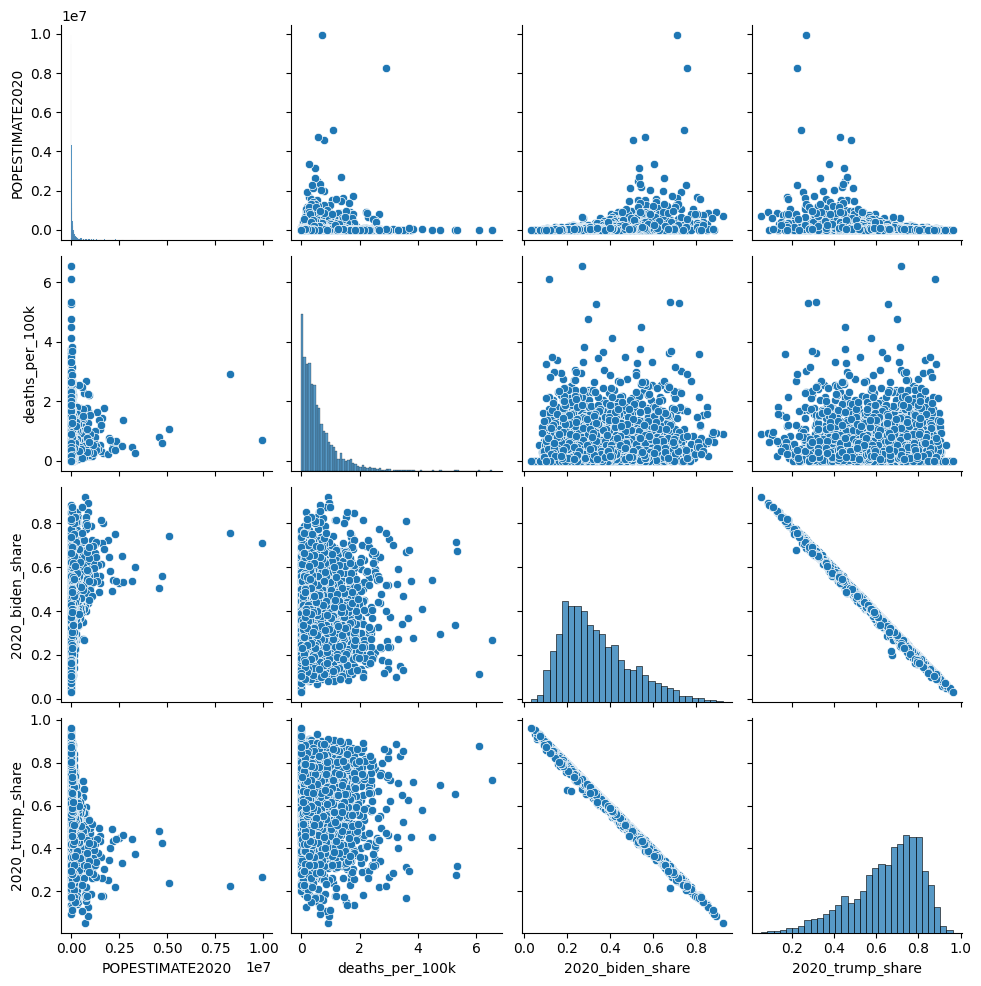

In [138]:
sns.pairplot(data=covid_votes, vars=['POPESTIMATE2020', 'deaths_per_100k', '2020_biden_share', '2020_trump_share'])

In [198]:
#not much to see yet. let's proceed with our first analysis — logistic regression by 2020 deaths per 100,000 
#on the trump_won binary for 2020.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

X = covid_votes[['POPESTIMATE2020', 'deaths_per_100k']]

y = covid_votes['trump_won_2020']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

logi_model_2020 = LogisticRegression(class_weight='balanced')
logi_model_2020.fit(X_train, y_train)

y_pred = logi_model_2020.predict(X_test)
print(logi_model_2020.coef_)
print(classification_report(y_test, y_pred))

[[-7.12939971e-06 -5.50858927e-01]]
              precision    recall  f1-score   support

           0       0.50      0.60      0.54       112
           1       0.91      0.87      0.89       510

    accuracy                           0.82       622
   macro avg       0.70      0.73      0.71       622
weighted avg       0.83      0.82      0.82       622



Not amazingly predictive, but it does a pretty good job once the class weights are balanced, to account for there being many more counties where Trump won (about 2500) than counties where he didn't (about 500). The population coefficient is tiny, whereas the Covid deaths coefficient is more substantial: for every additional death per 100,000 people, the log-odds of Trump winning that county decrease by about 5.51. So higher death rates are associated with a lower chance of Trump winning. We can plot the ROC curve to get a better picture of accuracy.

0.7829306722689076


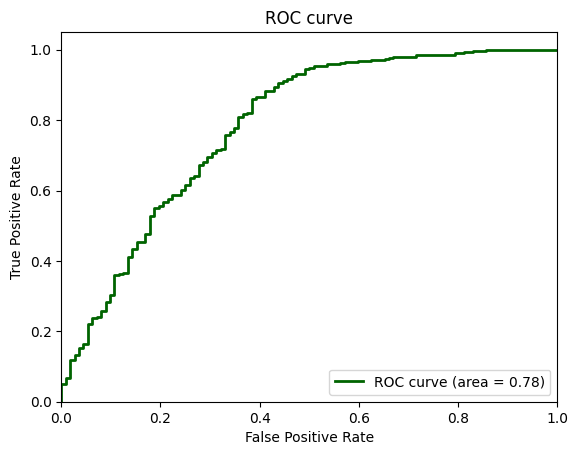

In [199]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

y_pred = logi_model_2020.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkgreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

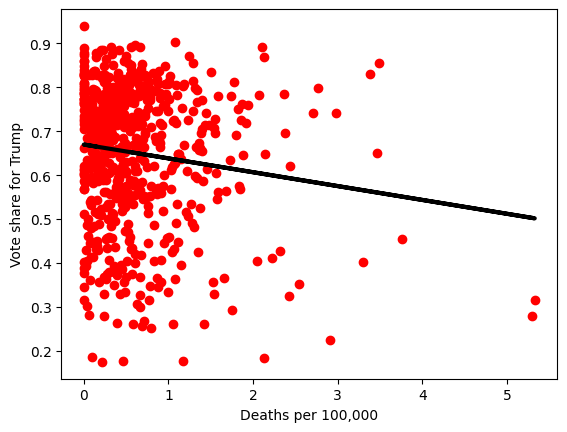

Coefficient: 
 [-0.0315439]
Coefficient of determination: 0.01


In [233]:
#linear regress 2020 trump share on deaths per 100k
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

linX = covid_votes[['deaths_per_100k']]
liny = covid_votes['2020_trump_share']
linX_train, linX_test, liny_train, liny_test = train_test_split(linX, liny, test_size = 0.2, random_state = 42)

vote_regr = linear_model.LinearRegression()
vote_regr.fit(linX_train, liny_train)
yhat = vote_regr.predict(linX_test)

#plot it
plt.scatter(linX_test, liny_test, color='red')
plt.plot(linX_test, yhat, color='black', linewidth=3)
plt.xlabel('Deaths per 100,000')
plt.ylabel('Vote share for Trump')
plt.show()

#stats
print("Coefficient: \n", vote_regr.coef_)
print("Coefficient of determination: %.2f" % r2_score(liny_test, yhat))

Oof, very bad R-squared value! Let's see if we can improve it by adding population into the regression. We can use a different library to see if we're in roughly the same realm.

In [237]:
import scipy.stats as stats
import statsmodels.formula.api as smf

covid_votes_stats = covid_votes.rename(columns={'2020_trump_share': 'trump_share_2020', '2016_trump_share': 'trump_share_2016'})
stats_model = smf.ols(formula='trump_share_2020 ~ deaths_per_100k', data=covid_votes_stats).fit()
print("Just deaths:", stats_model.summary())

Just deaths:                             OLS Regression Results                            
Dep. Variable:       trump_share_2020   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     46.98
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           8.62e-12
Time:                        20:49:10   Log-Likelihood:                 1294.8
No. Observations:                3109   AIC:                            -2586.
Df Residuals:                    3107   BIC:                            -2574.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6684   

The good news: Very similar coefficient for deaths per capita and very similar R-squared value. The bad news: That R-squared value is very low! Let's see if adding in population helps.

In [246]:
#introduce population
pop_model = smf.ols(formula='trump_share_2020 ~ deaths_per_100k + POPESTIMATE2020', 
                    data=covid_votes_stats).fit()
print("Deaths and pop:", pop_model.summary())

Deaths and pop:                             OLS Regression Results                            
Dep. Variable:       trump_share_2020   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     218.6
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           1.52e-89
Time:                        20:56:13   Log-Likelihood:                 1476.2
No. Observations:                3109   AIC:                            -2946.
Df Residuals:                    3106   BIC:                            -2928.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6814

In [245]:
all_model = smf.ols(formula=
                    'trump_share_2020 ~ deaths_per_100k + POPESTIMATE2020 + trump_share_2016', 
                    data=covid_votes_stats).fit()
print("Deaths, pop and 2016:", all_model.summary())

Deaths, pop and 2016:                             OLS Regression Results                            
Dep. Variable:       trump_share_2020   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 3.494e+04
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:53:25   Log-Likelihood:                 6787.3
No. Observations:                3109   AIC:                        -1.357e+04
Df Residuals:                    3105   BIC:                        -1.354e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         

Ha, that fixed our R-squared value right up! But this model actually doesn't really tell us anything about our desired topic (the effect of Covid-19 deaths on the 2020 election results); it just tells us that counties that voted for Trump in 2016 also tended to vote for him in 2020. Still, it's nice to see it working out the way you'd expect it to.

And speaking of the 2016 results, there's one more thing I'm interested to explore: Whether the pandemic had any effect on the change in share of the vote Trump won. I created a new variable, `trump_change`, that allows us to address this question. It's important to note that `trump_change` doesn't tell us anything about whether Trump actually won a county, only how much and in what direction that county shifted in 2020 as compared to 2016. Negative values indicate a shift toward less Republican, positive values indicate a shift toward more Republican. So for instance, if Trump received 75 percent of a county's votes in 2016 but only 55 percent of its votes in 2020, the `trump_change` score of -20 would indicate a shift leftward, even if he still won the county in 2020.

We'll regress Covid deaths per capita on this new variable.

In [248]:
shift_model = smf.ols(formula='trump_change ~ deaths_per_100k', data=covid_votes_stats).fit()
print("Shift model:", shift_model.summary())

Shift model:                             OLS Regression Results                            
Dep. Variable:           trump_change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.237
Date:                Mon, 23 Sep 2024   Prob (F-statistic):             0.0126
Time:                        21:06:50   Log-Likelihood:                 6767.6
No. Observations:                3109   AIC:                        -1.353e+04
Df Residuals:                    3107   BIC:                        -1.352e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0160   

In [250]:
full_shift_model = smf.ols(formula=
                           'trump_change ~ deaths_per_100k + POPESTIMATE2020 + trump_share_2020', 
                           data=covid_votes_stats).fit()
print("Shift model:", full_shift_model.summary())

Shift model:                             OLS Regression Results                            
Dep. Variable:           trump_change   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     73.80
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           4.17e-46
Time:                        21:07:50   Log-Likelihood:                 6871.5
No. Observations:                3109   AIC:                        -1.374e+04
Df Residuals:                    3105   BIC:                        -1.371e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0126

Unfortunately, there's not much to say here either. Deaths per capita has a significant coefficient, but a very small and not very predictive one.

Although I was disappointed not to have found a publishable result, I learned a lot, especially about data cleaning and merging datasets from different sources.

As both a journalist and a data scientist, I try to go into projects with an open mind — and that means living with the possibility of finding different results than expected.

The relative severity of the Covid-19 pandemic in a particular county as of Election Day 2020 turns out not to have been highly predictive of who that county voted for, which in itself is pretty interesting. More than 200,000 people had already died in the U.S. by that point, and it’s perhaps indicative of just how polarized the country’s politics are that those deaths seem not to have had an effect on votes.

If a future researcher wanted to improve on this work, I would suggest also finding another dataset that details demographic data for each county and exploring the relationships between, for example, race, income, education and election results (and Covid severity).
